<a href="https://colab.research.google.com/github/EdH66/Colab_notebooks/blob/main/Multi_image_FixedFeatureExtraction_PyTorchandResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-image augmentation and tuning Script with ResNet**

1.   Connect colab notebook to google drive






In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inport libraries

In [4]:
import torch
import torch .nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import os

2. Setup transform functions for agumentation and normalisation of training and validation data sets. Convert to tensors. Now use Pytorch library not PIL ibrary

In [5]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
}

3. Load data from google drive into the dataloaders (Train and Val) and print data size

In [7]:
#Data path
data_dir = "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Classification Dataset/"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
for x in ['Train', 'Val']}

#Define Train and Validation Dataloaders
dataloaders = {x:torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
for x in ['Train', 'Val']}

dataset_sizes = {x: len(Datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = Datasets['Val'].classes
print(class_names)


{'Train': 303, 'Val': 49}
['Bread', 'Coffee', 'Pasta']


4. Define a "device" variable for cuda to use GPU. Alternative CPU allowed.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

5. Define model training parameters

In [9]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




6. Visualise the model using the imshow function

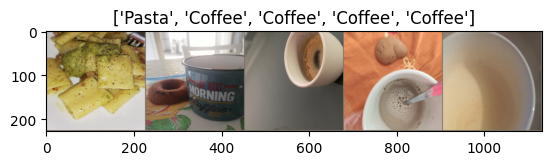

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

7. Setup transfer learning by fine tuning

In [12]:
import torchvision
from torchvision import models


*NB. Choose here if gradients are computed across the network by backpropagation using 'param.requires_grad = True' or stay fixed (fixed feature extraction) while only the last connected layer will be updated 'param.requires_grad = False' and select fixed feature extractor at the end. *

In [16]:
#Transfer Learning by with pretrained Resnet101 Model as fixed feature extractor
#Load Resnet101 pretained Model
Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
#Resnet101 = models.resnet101(weights=True)
#Print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    #param.requires_grad = True # to all gradients to be updated by backpropagation
    param.requires_grad = False # to freeze all parameters so that gradients not computed by backpropagation

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

#Resnet_fineTuning = Resnet101.to(device)
#if using 'fixed feature extractor' to only train last fully connected layer use code below
Resnet_featureExtractor = Resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


8. Model hyperparameter optimisation setup

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [19]:
#Define optimisation algorithm for either fine tunning or fixed feature extraction
#optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001) # lr = the learnnig rate decay after each epoch step size below
optimizer = optim.SGD(Resnet_featureExtractor.fc.parameters(), lr=0.00001) # lr = the learnnig rate decay after each epoch step size below. FC is final connected layer

#Decay LR by a factor of 0.1 every 7 ephochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

9. Finetune the model (apply varaibles defined above).
10. Save the model to google drive

In [20]:
%%time
#Time execution of model training
#model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
#torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_fineTuning.pth")
model_featureExtractor = train_model(Resnet_featureExtractor, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_featureExtractor, "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_featureExtractor.pth")


Epoch 0/19
----------
Train Loss: 1.1367 Acc: 0.3861
Val Loss: 1.2339 Acc: 0.1224

Epoch 1/19
----------
Train Loss: 1.1354 Acc: 0.3861
Val Loss: 1.2420 Acc: 0.1020

Epoch 2/19
----------
Train Loss: 1.1366 Acc: 0.3861
Val Loss: 1.2210 Acc: 0.1224

Epoch 3/19
----------
Train Loss: 1.1279 Acc: 0.3828
Val Loss: 1.1989 Acc: 0.1224

Epoch 4/19
----------
Train Loss: 1.1340 Acc: 0.3762
Val Loss: 1.1999 Acc: 0.1633

Epoch 5/19
----------
Train Loss: 1.1147 Acc: 0.3762
Val Loss: 1.1931 Acc: 0.1633

Epoch 6/19
----------
Train Loss: 1.1150 Acc: 0.3828
Val Loss: 1.2008 Acc: 0.1020

Epoch 7/19
----------
Train Loss: 1.1262 Acc: 0.4026
Val Loss: 1.1905 Acc: 0.1837

Epoch 8/19
----------
Train Loss: 1.1214 Acc: 0.3663
Val Loss: 1.1814 Acc: 0.1633

Epoch 9/19
----------
Train Loss: 1.1184 Acc: 0.3795
Val Loss: 1.1670 Acc: 0.1837

Epoch 10/19
----------
Train Loss: 1.1089 Acc: 0.3696
Val Loss: 1.1976 Acc: 0.1837

Epoch 11/19
----------
Train Loss: 1.1143 Acc: 0.3927
Val Loss: 1.1842 Acc: 0.2041

Ep

11. Load the saved model from google drive
12. Visualise the saved model

In [21]:
#Resnet_fineTuning = torch.load('/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_fineTuning.pth')
Resnet_featureExtractor = torch.load('/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_featureExtractor.pth')


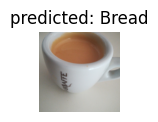

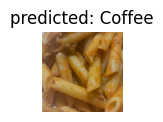

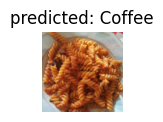

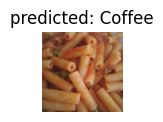

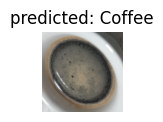

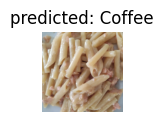

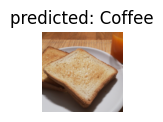

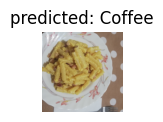

In [22]:
#visualize_model(Resnet_fineTuning)
visualize_model(Resnet_featureExtractor)